In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import xlsxwriter as xw
import pathlib
import pytz

%matplotlib inline

In [2]:
#--------------------------------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
#path = r'X:\CIS-PD Study\Subjects'
#--------------------------------------------------------------------------------------------------------------------------------


complete = list(['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping',
           'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #3: Pronation-Supination',
           'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility',
           'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait',
           'MDS-UPDRS #8: Postural Stability', 'MDS-UPDRS #9: Postural Hand Tremor',
           'MDS-UPDRS #10: Kinetic Hand Tremor', 'MDS-UPDRS #11: Rest Tremor',
           'Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
           'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
           'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
           'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
           'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
           'Motor #12: Folding Towels', 'Motor #13: Sitting'])


def process_annotations(path):
#--------------------------------------------------------------------------------------------------------------------------------
# Processes raw annotations file to extract start / end timestamps and remove unnecessary data
#
# Inputs:  path - filepath of the subject folder containing annotations.csv
#
# Outputs: df - dataframe containing list of activities and their start / end timestamps
#--------------------------------------------------------------------------------------------------------------------------------
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    
    testInfo = df[df.EventType == 'Testing Day'].dropna(how='any', axis=0)
    testInfo['Start Timestamp (ms)'] = pd.to_datetime(testInfo['Start Timestamp (ms)'], unit='ms', utc=True).dt.tz_localize('UTC').dt.tz_convert('US/Central')
    del testInfo['Stop Timestamp (ms)']
    del testInfo['EventType']
    del df['Value']
    
    testInfo = testInfo.rename(columns = {'Value':'Day', 'Start Timestamp (ms)':'Date'}).reset_index(drop=True)
    testInfo['Date'] = testInfo['Date'].dt.date
    
    df = df[(df.EventType != 'Testing Day')]

    # RESIDUAL: Separation into Day 1 and Day 2 data, may re-include at later time
    #Day1 = testInfo.loc[testInfo['Day'] == 'DAY 1', 'Date']
    #Day2 = testInfo.loc[testInfo['Day'] == 'DAY 2', 'Date']

    #d1_df = process_activities(df[df['Start Timestamp (ms)'].dt.date.isin(Day1)].reset_index(drop=True)).set_index('EventType')
    #d2_df = process_activities(df[df['Start Timestamp (ms)'].dt.date.isin(Day2)].reset_index(drop=True)).set_index('EventType')
    
    sorter = set(df.EventType.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))
        
    df['EventType_Rank'] = df['EventType'].map(sorterIndex)
    df['Cycle'] = df.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['EventType_Rank']
    df[df['EventType'].str.contains('MDS-UPDRS')] = df[df['EventType'].str.contains('MDS-UPDRS')].replace(to_replace={'Cycle': {2: 3}})
    df[df['EventType'].str.contains('Heart')] = df[df['EventType'].str.contains('Heart')].replace(to_replace={'Cycle': {1: 'NaN', 2: 'NaN'}})
    df = df.reset_index(drop=True).set_index('EventType')
    
    # return d1_df, d2_df, df
    return df

In [3]:
def extract_data(SubID, path):
#--------------------------------------------------------------------------------------------------------------------------------
# For a given subject, extracts and separates accelerometer, gyroscope, and EMG/ECG data into trials and sensor per activity
#
# Inputs: SubID - string of numbers corresponding to the subject ID
#         path - system path to corresponding subject's raw data files
#
# Outputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                     accelerometer + gyroscope or accelerometer + EMG/ECG data. Every key within this dictionary is a dictionary
#--------------------------------------------------------------------------------------------------------------------------------
    timestamps = process_annotations(path)
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            if filenames.endswith('elec.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete}

    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete:

        startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
        endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, len(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, len(startTimestamp)):

            startTime = startTimestamp[trials]
            endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]

                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]

                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]

                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    return act_dict

In [4]:
path3 = r'C:\users\Andrew\Documents\PD Study Data\RawData'
SubID = '1004'

act_dict = extract_data(SubID, os.path.join(path3, SubID))

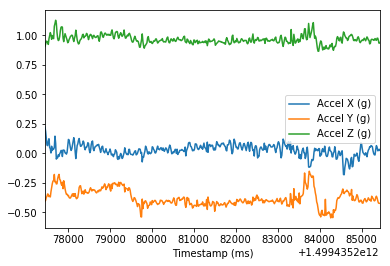

In [5]:
dat = pd.DataFrame(act_dict['Motor #8: Typing on a Computer'][0])
dat.loc['accel', 'dorsal_hand_right'][0:500].plot()

In [6]:
SubID2 = '1029'

act_dict2 = extract_data(SubID2, os.path.join(path3, SubID2))

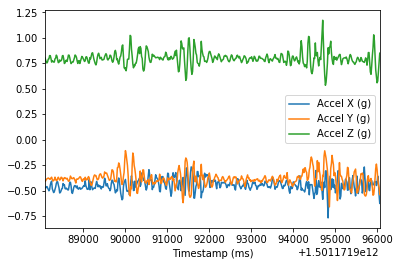

In [7]:
# Subject 1029 - OFF
dat2 = pd.DataFrame(act_dict2['Motor #8: Typing on a Computer'][0])
dat2.loc['accel', 'dorsal_hand_right'][0:500].plot()

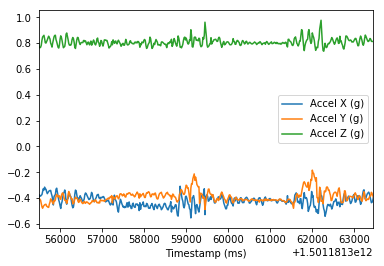

In [8]:
# Subject 1029 - ON
dat3 = pd.DataFrame(act_dict2['Motor #8: Typing on a Computer'][5])
dat3.loc['accel', 'dorsal_hand_right'][0:500].plot()

In [9]:
path2 = r'C:\Users\Andrew\Documents\PD Study Data\RawData'

subjects = os.listdir(path2)

for subjs in subjects:
    print(os.path.join(path2, subjs))

C:\Users\Andrew\Documents\PD Study Data\RawData\1004
C:\Users\Andrew\Documents\PD Study Data\RawData\1016
C:\Users\Andrew\Documents\PD Study Data\RawData\1018
C:\Users\Andrew\Documents\PD Study Data\RawData\1019
C:\Users\Andrew\Documents\PD Study Data\RawData\1020
C:\Users\Andrew\Documents\PD Study Data\RawData\1024
C:\Users\Andrew\Documents\PD Study Data\RawData\1029
